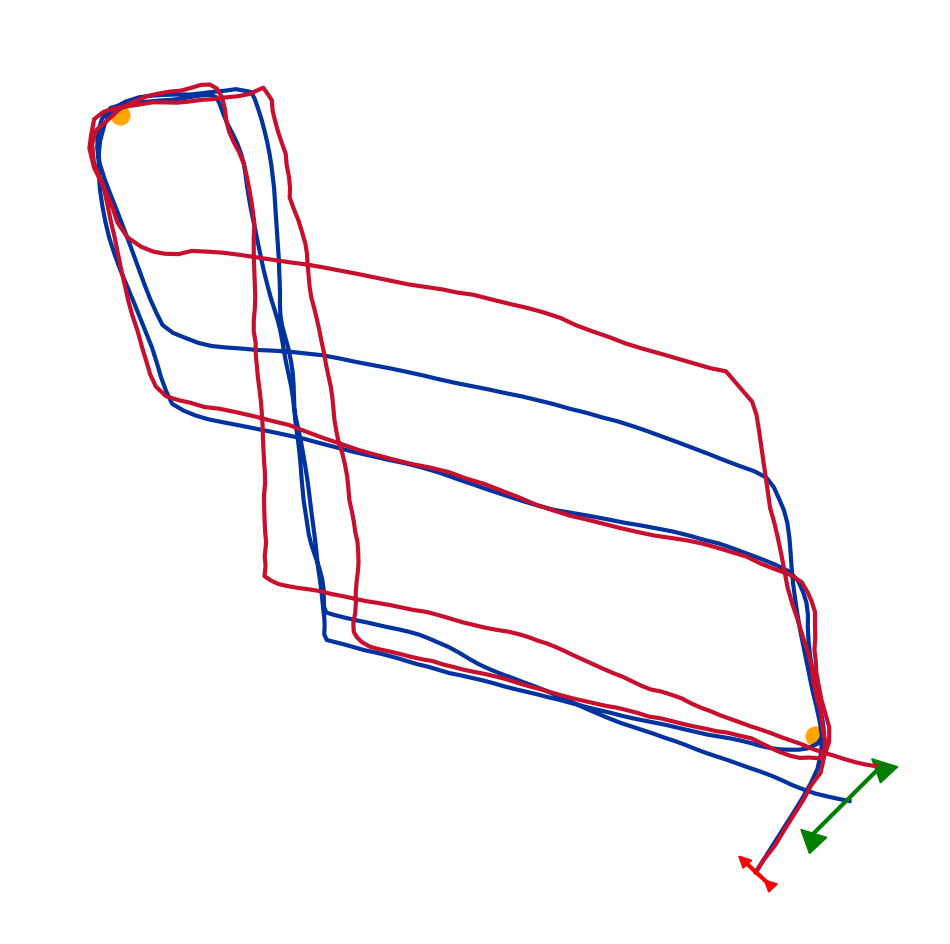

Map created: map.png


In [14]:
import os
import gpxpy
import math
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta

# Functions

def move_point(lat, lon, bearing_deg, distance_m):
    R = 6371000
    bearing = math.radians(bearing_deg)
    lat1 = math.radians(lat)
    lon1 = math.radians(lon)

    lat2 = math.asin(
        math.sin(lat1) * math.cos(distance_m / R) +
        math.cos(lat1) * math.sin(distance_m / R) * math.cos(bearing)
    )

    lon2 = lon1 + math.atan2(
        math.sin(bearing) * math.sin(distance_m / R) * math.cos(lat1),
        math.cos(distance_m / R) - math.sin(lat1) * math.sin(lat2)
    )

    return math.degrees(lat2), math.degrees(lon2)


def distance_m(lat1, lon1, lat2, lon2):
    R = 6371000
    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (
        math.sin(dlat/2)**2 +
        math.cos(math.radians(lat1)) *
        math.cos(math.radians(lat2)) *
        math.sin(dlon/2)**2
    )
    return 2 * R * math.asin(math.sqrt(a))


def load_gpx(path):
    with open(path, "r") as f:
        gpx = gpxpy.parse(f)

    pts, tms = [], []
    for tr in gpx.tracks:
        for sg in tr.segments:
            for p in sg.points:
                pts.append((p.latitude, p.longitude))
                tms.append(p.time)

    return pts, tms


# GPS track load

######################################
# Insert your directory to gpx files #
######################################

directory_p=""
directory_m=""


p_pts, p_times = load_gpx(directory_p)
m_pts, m_times = load_gpx(directory_m)

regatta_day = p_times[0].date()

def T(h, m, s):
    return datetime(regatta_day.year, regatta_day.month, regatta_day.day,h, m, s, tzinfo=timezone.utc)

######################################
# Insert manually informations       #
######################################

START    = T(10, 32, 3)
FINISH_p = T(10, 38, 12)
FINISH_m = T(10, 38, 13)

# Setting race course points
mark1 = {"lat": 39.221052080322307, "lon": 9.211524691772459}
mark4 = {"lat": 39.214400,          "lon": 9.220440}

committee = {"lat": 39.2140731811523, "lon": 9.22128009796143}

# Start line
pin_lat, pin_lon = move_point(committee["lat"], committee["lon"], 223, 115)
pin = {"lat": pin_lat, "lon": pin_lon}

# Selecting GPS track between start and end of the race

def filter_track(points, times, finish):
    return [(lat,lon) for (lat,lon), t in zip(points,times) if START <= t <= finish]

p_track = filter_track(p_pts, p_times, FINISH_p)
m_track = filter_track(m_pts, m_times, FINISH_m)

# Map creation
center_lat = (committee["lat"] + pin["lat"]) / 2
center_lon = (committee["lon"] + pin["lon"]) / 2

def to_xy(lat, lon, lat0, lon0):
    R = 6371000
    x = (lon - lon0) * np.cos(np.radians(lat0)) * (np.pi/180) * R
    y = (lat - lat0) * (np.pi/180) * R
    return x, y

# Conversions
p_xy  = [to_xy(lat,lon,center_lat,center_lon) for lat,lon in p_track]
m_xy  = [to_xy(lat,lon,center_lat,center_lon) for lat,lon in m_track]

committee_xy = to_xy(committee["lat"], committee["lon"], center_lat, center_lon)
pin_xy       = to_xy(pin["lat"],       pin["lon"],       center_lat, center_lon)
mark1_xy     = to_xy(mark1["lat"],     mark1["lon"],     center_lat, center_lon)
mark4_xy     = to_xy(mark4["lat"],     mark4["lon"],     center_lat, center_lon)


# Map parametres (editable)
import numpy as np
import matplotlib.pyplot as plt

BACKGROUND_COLOR   = "white"   # lasciato per compatibilità, non usato come sfondo

LINE_WIDTH_TRACK   = 3
LINE_WIDTH_START   = 3
LINE_WIDTH_FINISH  = 3

BOE_SIZE       = 180
TRIANGLE_SIZE  = 27
TRACK_ALPHA    = 1.0

WIND_DIRECTION = 315
WIND_LENGTH    = 50
FINISH_LINE_LENGTH = 20

LABEL_OFFSET_X = 15
LABEL_OFFSET_Y = 15


def draw_triangle(x, y, size, angle_deg, color):
    ang = np.radians(angle_deg)
    L = size
    pts = np.array([
        [0,  L/2],
        [-L/2, -L/2],
        [ L/2, -L/2]
    ])

    R = np.array([
        [np.cos(ang), -np.sin(ang)],
        [np.sin(ang),  np.cos(ang)]
    ])

    pts_rot = pts @ R.T + np.array([x, y])
    plt.fill(pts_rot[:, 0], pts_rot[:, 1], color=color)



fig = plt.figure(figsize=(12, 12))
ax = plt.gca()

fig.patch.set_alpha(0)
ax.patch.set_alpha(0)


plt.plot([x for x, y in p_xy], [y for x, y in p_xy],
         color="#0033A0", linewidth=LINE_WIDTH_TRACK, alpha=TRACK_ALPHA)

plt.plot([x for x, y in m_xy], [y for x, y in m_xy],
         color="#C8102E", linewidth=LINE_WIDTH_TRACK, alpha=TRACK_ALPHA)



plt.scatter(mark1_xy[0], mark1_xy[1], color="orange", s=BOE_SIZE)
plt.scatter(mark4_xy[0], mark4_xy[1], color="orange", s=BOE_SIZE)

plt.text(mark1_xy[0] + LABEL_OFFSET_X, mark1_xy[1] - LABEL_OFFSET_Y,
         "Mark 1", color="white")
plt.text(mark4_xy[0] - LABEL_OFFSET_X - 35, mark4_xy[1] + LABEL_OFFSET_Y,
         "Mark 4", color="white")


plt.plot([committee_xy[0], pin_xy[0]],
         [committee_xy[1], pin_xy[1]],
         color="green", linewidth=LINE_WIDTH_START)

draw_triangle(committee_xy[0], committee_xy[1], TRIANGLE_SIZE, 45, "green")
draw_triangle(pin_xy[0],       pin_xy[1],       TRIANGLE_SIZE, 45, "green")

plt.text(committee_xy[0] - 20, committee_xy[1] + 30,
         "Start Line", color="white")


angle_rad = np.radians(WIND_DIRECTION)

finish_center_xy = ((p_xy[-1][0] + m_xy[-1][0]) / 2,(p_xy[-1][1] + m_xy[-1][1]) / 2,)

finishA_xy = (finish_center_xy[0] + np.cos(angle_rad) * FINISH_LINE_LENGTH,
              finish_center_xy[1] + np.sin(angle_rad) * FINISH_LINE_LENGTH,)
finishB_xy = (finish_center_xy[0] - np.cos(angle_rad) * FINISH_LINE_LENGTH,
              finish_center_xy[1] - np.sin(angle_rad) * FINISH_LINE_LENGTH,)

wind_tip_xy = (finish_center_xy[0] + np.cos(angle_rad) * WIND_LENGTH,
               finish_center_xy[1] + np.sin(angle_rad) * WIND_LENGTH,)

plt.plot([finishA_xy[0], finishB_xy[0]],
         [finishA_xy[1], finishB_xy[1]],
         color="red", linewidth=LINE_WIDTH_FINISH)

draw_triangle(finishA_xy[0], finishA_xy[1], TRIANGLE_SIZE / 2, 45, "red")
draw_triangle(finishB_xy[0], finishB_xy[1], TRIANGLE_SIZE / 2, 45, "red")

plt.text(finishA_xy[0] - 75, finishA_xy[1] + 50,"Finish Line", color="white")

plt.arrow(mark1_xy[0] - 75, mark1_xy[1] + 75,
          wind_tip_xy[0] - finish_center_xy[0],wind_tip_xy[1] - finish_center_xy[1],
          head_width=12, head_length=14,linewidth=2, color="white")

plt.text(mark1_xy[0] - 45, mark1_xy[1] + 55,f"Wind {WIND_DIRECTION}°", color="white")

plt.axis("off")

plt.savefig("mappa.png",dpi=300,bbox_inches="tight",transparent=True)

plt.show()


print("Map created: map.png")


In [15]:
# ANALYSIS 

# Functions for Tack Analysis 

# Compute the bearing between two points
def bearing_deg(lat1, lon1, lat2, lon2):
    y = math.sin(math.radians(lon2 - lon1)) * math.cos(math.radians(lat2))
    x = (math.cos(math.radians(lat1)) * math.sin(math.radians(lat2))
         - math.sin(math.radians(lat1)) * math.cos(math.radians(lat2))
         * math.cos(math.radians(lon2 - lon1)))
    return (math.degrees(math.atan2(y, x)) + 360) % 360

# Compute SOG for each point
def sog_list(pts, times):
    sog = []
    for i in range(len(pts)):
        if i == 0:
            sog.append(0)
        else:
            d = distance_m(*pts[i-1], *pts[i])
            dt = (times[i] - times[i-1]).total_seconds()
            sog.append(d/dt if dt > 0 else sog[-1])
    return np.array(sog)

# Compute the distance from the mark
def dist_to_mark(pts, mark):
    return np.array([distance_m(lat,lon,mark["lat"],mark["lon"]) for lat,lon in pts])

# Find the closes index to the tagret time
def find_closest_time_index(times, target):
    return min(range(len(times)), key=lambda i: abs((times[i] - target).total_seconds()))


# Speed and global distances
p_sog = sog_list(p_pts, p_times)
m_sog = sog_list(m_pts, m_times)

p_dmark = dist_to_mark(p_pts, mark1)
m_dmark = dist_to_mark(m_pts, mark1)


# Tack analysis
def analyze_tack_by_time(target_time, pts, times, sog, dmark):

    idx = find_closest_time_index(times, target_time)
    t0 = times[idx]

    t_start = t0 - timedelta(seconds=15)
    t_end = t0 + timedelta(seconds=15)

    t_rel, sog_win, d_win, pts_win = [], [], [], []

    for latlon, t, v, dm in zip(pts, times, sog, dmark):
        if t_start <= t <= t_end:
            t_rel.append((t - t0).total_seconds())
            sog_win.append(v)
            d_win.append(dm)
            pts_win.append(latlon)

    if len(sog_win) < 3:
        return {k: np.nan for k in
                ["speed_before","speed_min","speed_after","speed_drop",
                 "recovery_time","distance_lost","vmg_drop","radius","turn_time",
                 "t_rel","sog_win"]}

    t_rel = np.array(t_rel)
    sog_win = np.array(sog_win)
    d_win = np.array(d_win)

    # Speed
    pre_speed = sog_win[t_rel < -1][-1]
    min_speed = sog_win.min()
    post_speed = sog_win[t_rel > 1][0]
    speed_drop = pre_speed - min_speed

    try:
        recovery_time = t_rel[np.where(sog_win >= pre_speed)[0][0]]
    except:
        recovery_time = np.nan

    # Distance loss
    pre_dist = d_win[t_rel < -1][-1]
    post_dist = d_win[t_rel > 1][0]
    lost = post_dist - pre_dist

    # VMG
    def compute_vmg(pts_local, sog_vals):
        vmgs = []
        for (lat,lon), v in zip(pts_local, sog_vals):
            br = bearing_deg(lat, lon, mark1["lat"], mark1["lon"])
            delta = abs(180 - br)
            vmgs.append(v * math.cos(math.radians(delta)))
        return np.array(vmgs)

    vmg_win = compute_vmg(pts_win, sog_win)
    vmg_pre = vmg_win[t_rel < -1][-1]
    vmg_min = vmg_win.min()
    vmg_drop = vmg_pre - vmg_min

    # Radius
    def curvature_radius(points):
        radii = []
        for i in range(1, len(points)-1):
            a = distance_m(*points[i-1], *points[i])
            b = distance_m(*points[i], *points[i+1])
            c = distance_m(*points[i-1], *points[i+1])
            if a*b*c == 0: continue
            s = (a+b+c)/2
            A = s*(s-a)*(s-b)*(s-c)
            if A <= 0: continue
            area = math.sqrt(A)
            radii.append((a*b*c)/(4*area))
        return np.nanmedian(radii) if radii else np.nan

    radius = curvature_radius(pts_win)

    # Turn time
    threshold = pre_speed - 0.5
    mask_turn = sog_win < threshold
    t_eff = (t_rel[mask_turn][-1] - t_rel[mask_turn][0]) if mask_turn.any() else 0

    return {
        "speed_before": pre_speed,
        "speed_min": min_speed,
        "speed_after": post_speed,
        "speed_drop": speed_drop,
        "recovery_time": recovery_time,
        "distance_lost": lost,
        "vmg_drop": vmg_drop,
        "radius": radius,
        "turn_time": t_eff,
        "t_rel": t_rel,
        "sog_win": sog_win
    }

###########################
# Setting tack parameters #
###########################

def TT(h,m,s):
    return datetime(regatta_day.year, regatta_day.month, regatta_day.day,
                    h,m,s, tzinfo=timezone.utc)

T_P1 = TT(10,32,52)
T_P2 = TT(10,33,40)
T_M1 = TT(10,33,2)
T_M2 = TT(10,33,44)

# Metric calculation
p_metrics = [analyze_tack_by_time(T_P1, p_pts, p_times, p_sog, p_dmark),
             analyze_tack_by_time(T_P2, p_pts, p_times, p_sog, p_dmark)]

m_metrics = [analyze_tack_by_time(T_M1, m_pts, m_times, m_sog, m_dmark),
             analyze_tack_by_time(T_M2, m_pts, m_times, m_sog, m_dmark)]


# Functions for Start Analysis 

# Extracting start window
def extract_window(points, times, center, before, after):
    t_start = center - timedelta(seconds=before)
    t_end   = center + timedelta(seconds=after)
    pts, ts = [], []
    for (lat,lon), t in zip(points, times):
        if t_start <= t <= t_end:
            pts.append((lat,lon))
            ts.append(t)
    return pts, ts

# Computing SOG
def compute_sog_window(pts, times):
    sog = [0]
    for i in range(1, len(pts)):
        d = distance_m(*pts[i-1], *pts[i])
        dt = (times[i] - times[i-1]).total_seconds()
        sog.append(d/dt if dt > 0 else sog[-1])
    return sog

# Computing Acceleration
def compute_accel(sog, times):
    acc = [0]
    for i in range(1, len(sog)):
        dv = sog[i] - sog[i-1]
        dt = (times[i] - times[i-1]).total_seconds()
        acc.append(dv/dt if dt > 0 else acc[-1])
    return acc


def time_relative(times, ref):
    return [(t - ref).total_seconds() for t in times]


#############################
# Setting window parameters #
#############################

WINDOW_BEFORE = 10
WINDOW_AFTER  = 10

p_win_pts, p_win_times = extract_window(p_pts, p_times, START, WINDOW_BEFORE, WINDOW_AFTER)
m_win_pts, m_win_times = extract_window(m_pts, m_times, START, WINDOW_BEFORE, WINDOW_AFTER)

p_sog_start = compute_sog_window(p_win_pts, p_win_times)
m_sog_start = compute_sog_window(m_win_pts, m_win_times)

p_acc_start = compute_accel(p_sog_start, p_win_times)
m_acc_start = compute_accel(m_sog_start, m_win_times)

t_p = time_relative(p_win_times, START)
t_m = time_relative(m_win_times, START)

print("Analysis OK")

Analysis OK


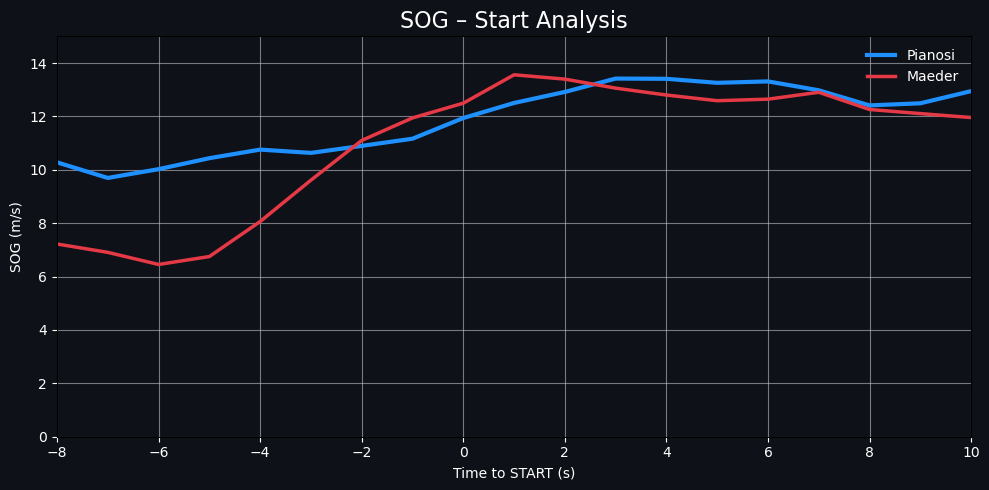

Saved PNG: start_sog.png


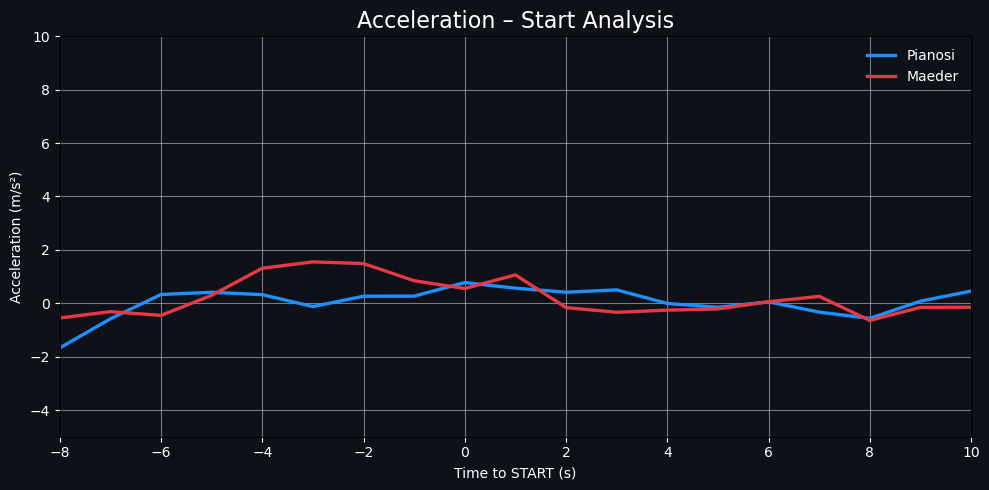

Saved PNG: start_acceleration.png


In [16]:
import matplotlib.pyplot as plt


# Color palette
color_p    = "#1E90FF"     
color_m    = "#E63946"     
grid_color = "#BFC3C9"
bg_color = "#0E1117" 

# SOG Analysis graph

fig = plt.figure(figsize=(10,5))
fig.patch.set_facecolor(bg_color)     
ax = fig.add_subplot(111)
ax.set_facecolor(bg_color)            

# Curve
ax.plot(t_p, p_sog_start, color=color_p, linewidth=3, label="Pianosi")
ax.plot(t_m, m_sog_start, color=color_m, linewidth=2.5, label="Maeder")


ax.set_title("SOG – Start Analysis", fontsize=16, color="white")
ax.set_xlabel("Time to START (s)", color="white")
ax.set_ylabel("SOG (m/s)", color="white")

ax.set_xlim([-8, 10])
ax.set_ylim([0, 15])


ax.grid(True, color=grid_color, alpha=0.6)


ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')


leg = ax.legend()
for text in leg.get_texts():
    text.set_color("white")
leg.get_frame().set_facecolor('none')   
leg.get_frame().set_edgecolor('none')   

plt.tight_layout()
plt.savefig("start_sog.png", dpi=300, bbox_inches="tight")
plt.show()

print("Saved PNG: start_sog.png")

# Acceleration Analysis

fig = plt.figure(figsize=(10,5))
fig.patch.set_facecolor(bg_color)
ax = fig.add_subplot(111)
ax.set_facecolor(bg_color)

# Curve
ax.plot(t_p, p_acc_start, color=color_p, linewidth=2.4, label="Pianosi")
ax.plot(t_m, m_acc_start, color=color_m, linewidth=2.4, label="Maeder")


ax.set_title("Acceleration – Start Analysis", fontsize=16, color="white")
ax.set_xlabel("Time to START (s)", color="white")
ax.set_ylabel("Acceleration (m/s²)", color="white")

ax.set_xlim([-8, 10])
ax.set_ylim([-5, 10])

# Grid
ax.grid(True, color=grid_color, alpha=0.6)

ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')


leg = ax.legend()
for text in leg.get_texts():
    text.set_color("white")
leg.get_frame().set_facecolor('none')   
leg.get_frame().set_edgecolor('none') 

plt.tight_layout()
plt.savefig("start_acceleration.png", dpi=300, bbox_inches="tight")
plt.show()
print("Saved PNG: start_acceleration.png")

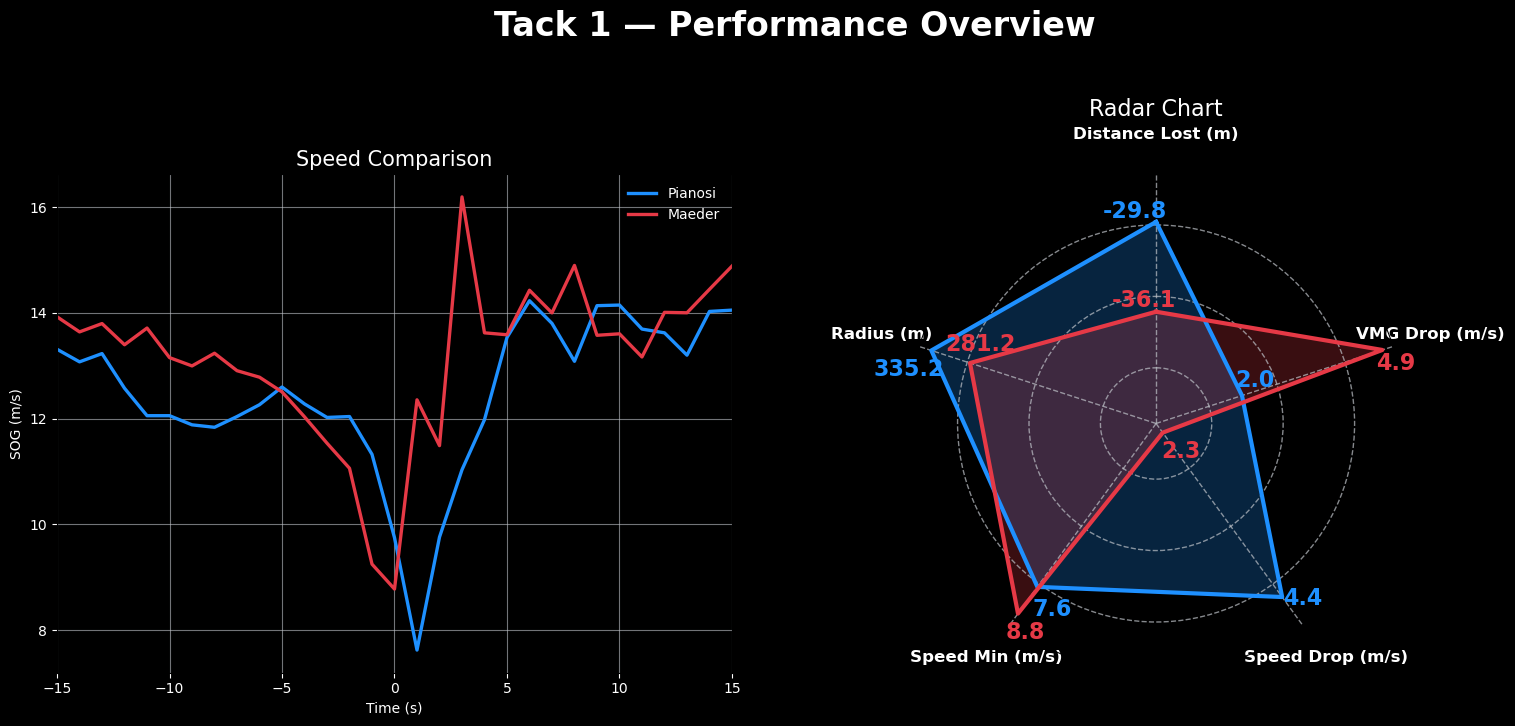

Saved PNG:tack1_full.png


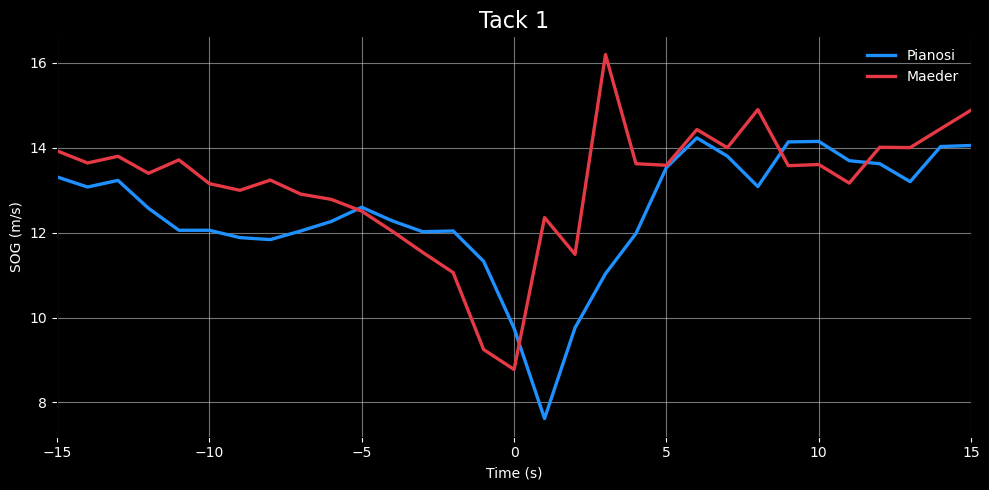

Saved PNG:tack1_speed.png


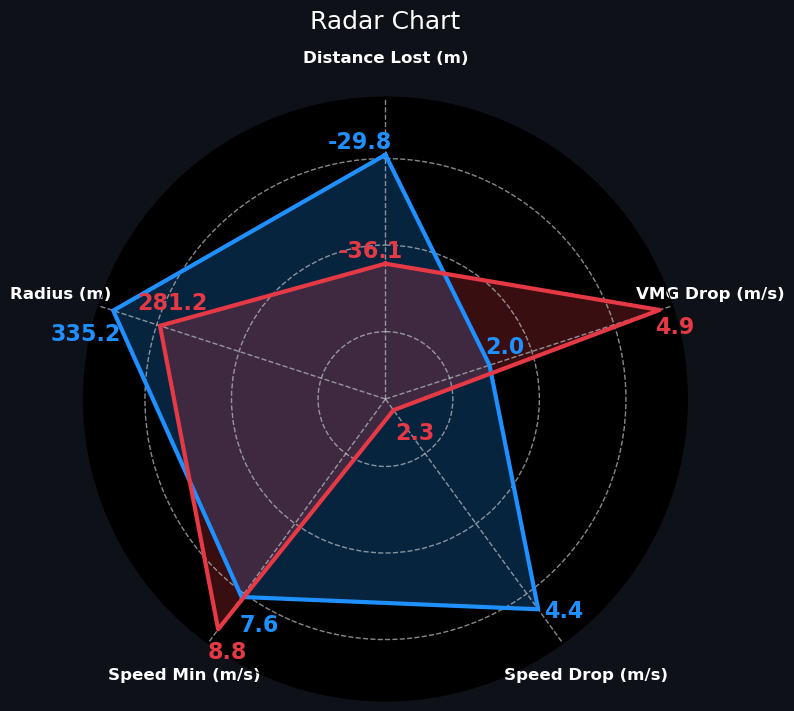

Saved PNG:tack1_radar.png


In [17]:
import matplotlib.pyplot as plt
import numpy as np


# Color palette

color_p    = "#1E90FF"     
color_m    = "#E63946"     
grid_color = "#BFC3C9"
bg_color = "0E1117"


# Radar builder

def build_radar(ax, P, M, min_ranges, max_ranges):

    categories = ["Distance Lost (m)", "VMG Drop (m/s)", "Speed Drop (m/s)",
                  "Speed Min (m/s)", "Radius (m)"]
    N = len(categories)
    angles = np.linspace(0, 2*np.pi, N, endpoint=False)
    angles = np.append(angles, angles[0])

    # Raw values
    P_raw = np.array([P[k] for k in ["distance_lost","vmg_drop","speed_drop","speed_min","radius"]], float)
    M_raw = np.array([M[k] for k in ["distance_lost","vmg_drop","speed_drop","speed_min","radius"]], float)

    min_ranges = np.array(min_ranges)
    max_ranges = np.array(max_ranges)
    ranges = max_ranges - min_ranges
    ranges[ranges == 0] = 1

    P_scaled = (P_raw - min_ranges) / ranges
    M_scaled = (M_raw - min_ranges) / ranges

    P_closed = np.append(P_scaled, P_scaled[0])
    M_closed = np.append(M_scaled, M_scaled[0])

    # Radar setup
    ax.set_facecolor(bg_color)
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    # Grid
    ax.set_yticks(np.linspace(0,1,5))
    ax.set_yticklabels([])
    ax.yaxis.grid(True, linestyle="--", linewidth=1, color=grid_color, alpha=0.7)
    ax.xaxis.grid(True, linestyle="--", linewidth=1, color=grid_color, alpha=0.7)

    # Categories
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=12, fontweight="bold", color="white")
    ax.tick_params(axis='x', pad=18)

    # Polygons
    ax.plot(angles, P_closed, color=color_p, linewidth=3)
    ax.fill(angles, P_closed, color=color_p, alpha=0.25)

    ax.plot(angles, M_closed, color=color_m, linewidth=3)
    ax.fill(angles, M_closed, color=color_m, alpha=0.25)

    # Label positions (editable)
    angle_offset_p = [-0.1, -0.10, -0.07, -0.12, -0.10]
    angle_offset_m = [-0.1,  0.07, -0.1, -0.07,  0.11]

    radius_offset_p = [0.04, 0.06, 0.05, 0.04, 0.06]
    radius_offset_m = [0.04, 0.03, 0.09, 0.04, -0.01]

    value_fontsize = 16
    value_weight = "bold"

    for i in range(N):

        ax.text(
            angles[i] + angle_offset_p[i],
            P_scaled[i] + radius_offset_p[i],
            f"{P_raw[i]:.1f}",
            color=color_p, fontsize=value_fontsize, fontweight=value_weight,
            ha="center", va="center"
        )

        ax.text(
            angles[i] + angle_offset_m[i],
            M_scaled[i] + radius_offset_m[i],
            f"{M_raw[i]:.1f}",
            color=color_m, fontsize=value_fontsize, fontweight=value_weight,
            ha="center", va="center"
        )


# Tack full graphs
def full_tack_plot(tack_id, P, M, min_ranges, max_ranges, filename):

    fig = plt.figure(figsize=(16, 7))
    fig.patch.set_facecolor("black")

    fig.suptitle(
        f"Tack {tack_id} — Performance Overview",
        fontsize=24, fontweight="bold", color="white", y=1.03
    )

    # Speed plot
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.set_facecolor("black")

    ax1.plot(P["t_rel"], P["sog_win"], color=color_p, linewidth=2.4, label="Pianosi")
    ax1.plot(M["t_rel"], M["sog_win"], color=color_m, linewidth=2.4, label="Maeder")

    ax1.set_xlim([-15, 15])
    ax1.set_xlabel("Time (s)", color="white")
    ax1.set_ylabel("SOG (m/s)", color="white")
    ax1.set_title("Speed Comparison", color="white", fontsize=15)
    ax1.grid(True, color=grid_color, alpha=0.6)

    ax1.tick_params(axis='x', colors='white')
    ax1.tick_params(axis='y', colors='white')

    leg = ax1.legend()
    for text in leg.get_texts():
        text.set_color("white")
    leg.get_frame().set_facecolor("black")
    leg.get_frame().set_alpha(0.0)
    # Radar plot
    ax2 = fig.add_subplot(1, 2, 2, polar=True)
    build_radar(ax2, P, M, min_ranges, max_ranges)
    ax2.set_title("Radar Chart", y=1.10, fontsize=16, color="white")

    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()


# Speed graph

def save_speed_plot(P, M, filename):
    fig = plt.figure(figsize=(10, 5))
    fig.patch.set_facecolor("black")

    ax = fig.add_subplot(111)
    ax.set_facecolor("0E1117")

    ax.plot(P["t_rel"], P["sog_win"], color=color_p, linewidth=2.4, label="Pianosi")
    ax.plot(M["t_rel"], M["sog_win"], color=color_m, linewidth=2.4, label="Maeder")

    ax.set_xlim([-15, 15])
    ax.set_xlabel("Time (s)", color="white")
    ax.set_ylabel("SOG (m/s)", color="white")
    ax.set_title("Tack 1", color="white", fontsize=16)

    ax.grid(True, color=grid_color, alpha=0.6)

    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')

    leg = ax.legend()
    for text in leg.get_texts():
        text.set_color("white")
        
    leg.get_frame().set_facecolor("black")
    leg.get_frame().set_alpha(0.0)
    
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()


# Radar graph

def save_radar_plot(P, M, min_ranges, max_ranges, filename):

    fig = plt.figure(figsize=(8, 8))
    fig.patch.set_facecolor("#0E1117")

    ax = fig.add_subplot(111, polar=True)
    build_radar(ax, P, M, min_ranges, max_ranges)

    ax.set_title("Radar Chart", y=1.10, fontsize=18, color="white")

    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()


min_ranges_1 = [-45, 0, 2, 0, 0]
max_ranges_1 = [-25, 5.5, 5, 10, 380]

full_tack_plot(
    tack_id=1,
    P=p_metrics[0],
    M=m_metrics[0],
    min_ranges=min_ranges_1,
    max_ranges=max_ranges_1,
    filename="tack1_full.png"
)
print("Saved PNG:tack1_full.png")


save_speed_plot(
    P=p_metrics[0],
    M=m_metrics[0],
    filename="tack1_speed.png"
)
print("Saved PNG:tack1_speed.png")
save_radar_plot(
    P=p_metrics[0],
    M=m_metrics[0],
    min_ranges=min_ranges_1,
    max_ranges=max_ranges_1,
    filename="tack1_radar.png"
)
print("Saved PNG:tack1_radar.png")

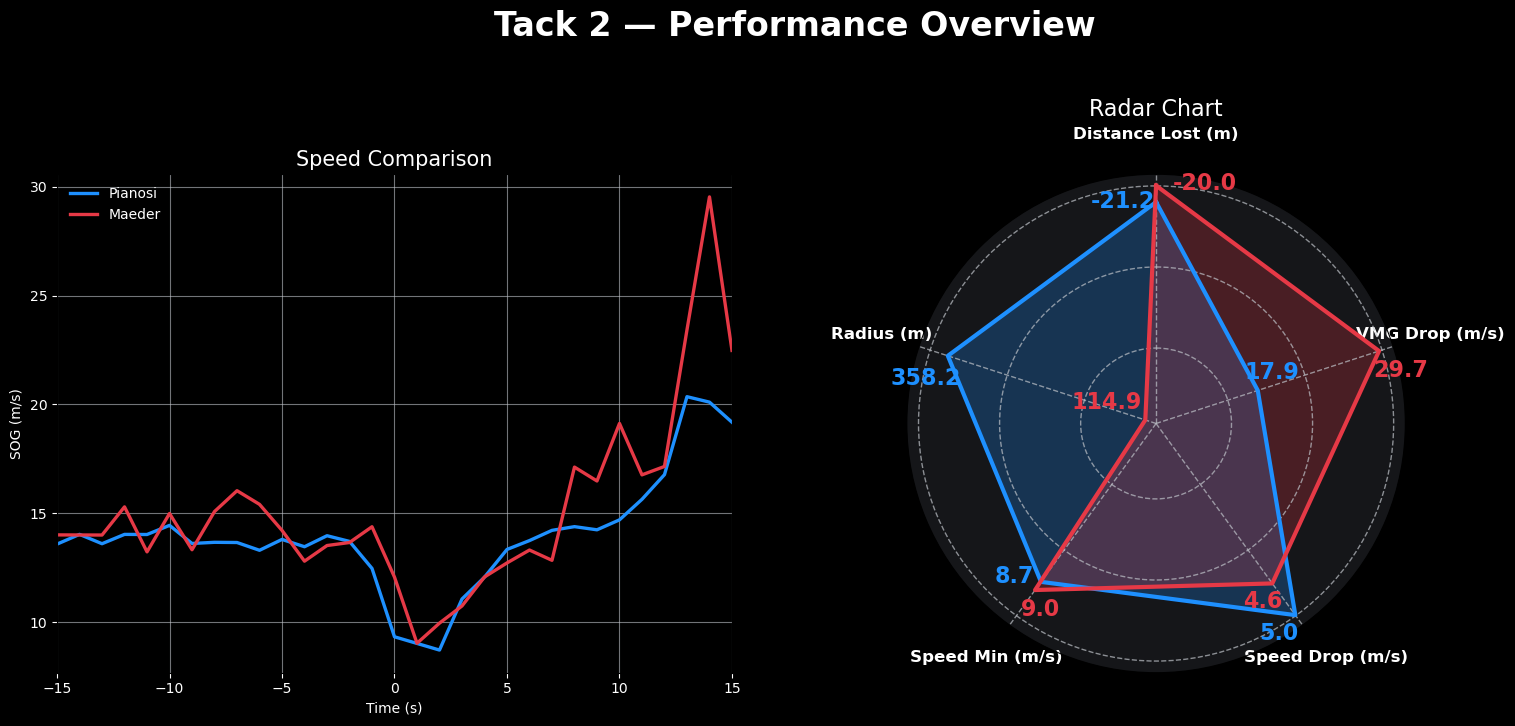

Saved PNG: tack2_full.png


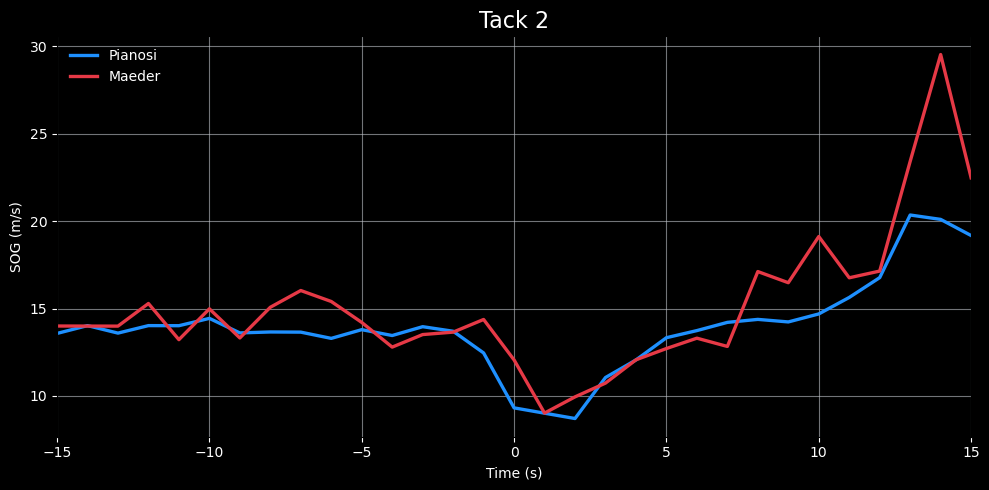

Saved PNG: tack2_speed.png


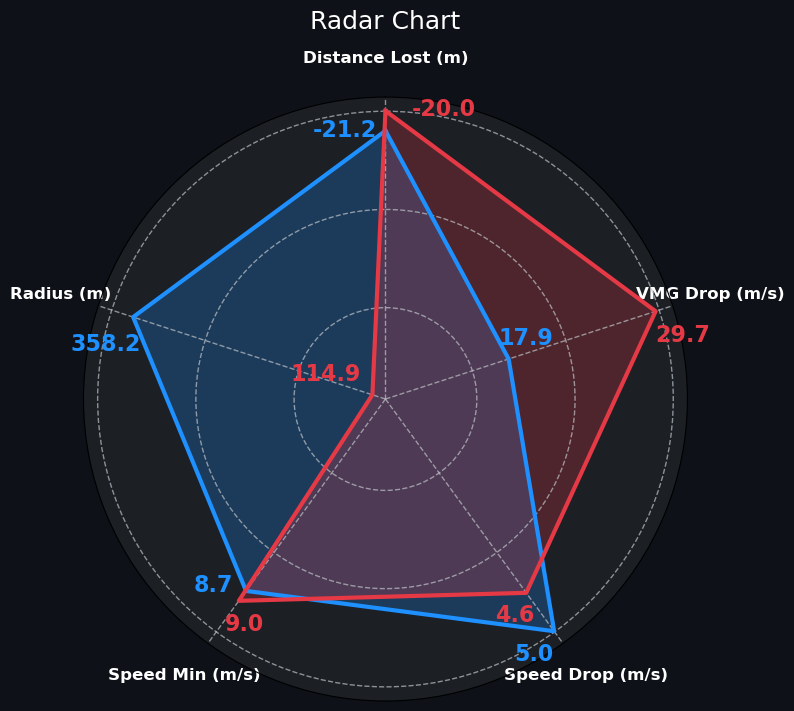

Saved PNG: tack2_radar.png


In [18]:
import matplotlib.pyplot as plt
import numpy as np


#  Color palette
color_p    = "#1E90FF"     
color_m    = "#E63946"     
grid_color = "#BFC3C9"

bg_color = (42/255, 45/255, 50/255, 0.50)

# Radar builder
def build_radar(ax, P, M, min_ranges, max_ranges):

    categories = ["Distance Lost (m)", "VMG Drop (m/s)", "Speed Drop (m/s)",
                  "Speed Min (m/s)", "Radius (m)"]
    N = len(categories)
    angles = np.linspace(0, 2*np.pi, N, endpoint=False)
    angles = np.append(angles, angles[0])

    # Raw values
    P_raw = np.array([P[k] for k in ["distance_lost","vmg_drop","speed_drop","speed_min","radius"]], float)
    M_raw = np.array([M[k] for k in ["distance_lost","vmg_drop","speed_drop","speed_min","radius"]], float)

    min_ranges = np.array(min_ranges)
    max_ranges = np.array(max_ranges)
    ranges = max_ranges - min_ranges
    ranges[ranges == 0] = 1

    P_scaled = (P_raw - min_ranges) / ranges
    M_scaled = (M_raw - min_ranges) / ranges

    P_closed = np.append(P_scaled, P_scaled[0])
    M_closed = np.append(M_scaled, M_scaled[0])

    # Radar setup
    ax.set_facecolor(bg_color)
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    # Grid
    ax.set_yticks(np.linspace(0,1,5))
    ax.set_yticklabels([])
    ax.yaxis.grid(True, linestyle="--", linewidth=1, color=grid_color, alpha=0.7)
    ax.xaxis.grid(True, linestyle="--", linewidth=1, color=grid_color, alpha=0.7)

    # Categories
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=12, fontweight="bold", color="white")
    ax.tick_params(axis='x', pad=18)

    # Polygons
    ax.plot(angles, P_closed, color=color_p, linewidth=3)
    ax.fill(angles, P_closed, color=color_p, alpha=0.25)

    ax.plot(angles, M_closed, color=color_m, linewidth=3)
    ax.fill(angles, M_closed, color=color_m, alpha=0.25)

    # Label parameters (editable)
    angle_offset_p = [-0.15, -0.10, 0.1, 0.12, -0.12]
    angle_offset_m = [0.2,  0.1, 0.09, -0.07,  0.08]

    radius_offset_p = [0.01, 0.06, 0.02, 0.04, 0.05]
    radius_offset_m = [0.02, 0.05, 0.03, 0.04, 0.13]

    value_fontsize = 16
    value_weight = "bold"

    for i in range(N):

        ax.text(
            angles[i] + angle_offset_p[i],
            P_scaled[i] + radius_offset_p[i],
            f"{P_raw[i]:.1f}",
            color=color_p, fontsize=value_fontsize, fontweight=value_weight,
            ha="center", va="center"
        )

        ax.text(
            angles[i] + angle_offset_m[i],
            M_scaled[i] + radius_offset_m[i],
            f"{M_raw[i]:.1f}",
            color=color_m, fontsize=value_fontsize, fontweight=value_weight,
            ha="center", va="center"
        )


# Tack full graphs

def full_tack_plot(tack_id, P, M, min_ranges, max_ranges, filename):

    fig = plt.figure(figsize=(16, 7))
    fig.patch.set_facecolor("black")

    fig.suptitle(
        f"Tack {tack_id} — Performance Overview",
        fontsize=24, fontweight="bold", color="white", y=1.03
    )

    # Speed plot
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.set_facecolor("black")

    ax1.plot(P["t_rel"], P["sog_win"], color=color_p, linewidth=2.4, label="Pianosi")
    ax1.plot(M["t_rel"], M["sog_win"], color=color_m, linewidth=2.4, label="Maeder")

    ax1.set_xlim([-15, 15])
    ax1.set_xlabel("Time (s)", color="white")
    ax1.set_ylabel("SOG (m/s)", color="white")
    ax1.set_title("Speed Comparison", color="white", fontsize=15)
    ax1.grid(True, color=grid_color, alpha=0.6)

    ax1.tick_params(axis='x', colors='white')
    ax1.tick_params(axis='y', colors='white')

    leg = ax1.legend()
    for text in leg.get_texts():
        text.set_color("white")

    leg.get_frame().set_facecolor("black")
    leg.get_frame().set_alpha(0.0)
    
    # Radar plot
    ax2 = fig.add_subplot(1, 2, 2, polar=True)
    build_radar(ax2, P, M, min_ranges, max_ranges)
    ax2.set_title("Radar Chart", y=1.10, fontsize=16, color="white")

    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()


# Speed graph

def save_speed_plot(P, M, filename):
    fig = plt.figure(figsize=(10, 5))
    fig.patch.set_facecolor("black")

    ax = fig.add_subplot(111)
    ax.set_facecolor("black")

    ax.plot(P["t_rel"], P["sog_win"], color=color_p, linewidth=2.4, label="Pianosi")
    ax.plot(M["t_rel"], M["sog_win"], color=color_m, linewidth=2.4, label="Maeder")

    ax.set_xlim([-15, 15])
    ax.set_xlabel("Time (s)", color="white")
    ax.set_ylabel("SOG (m/s)", color="white")
    ax.set_title("Tack 2", color="white", fontsize=16)

    ax.grid(True, color=grid_color, alpha=0.6)

    # *** FIX ***
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')

    leg = ax.legend()
    for text in leg.get_texts():
        text.set_color("white")

    leg.get_frame().set_facecolor("black")
    leg.get_frame().set_alpha(0.0)

    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()


# Radar graph

def save_radar_plot(P, M, min_ranges, max_ranges, filename):

    fig = plt.figure(figsize=(8, 8))
    fig.patch.set_facecolor("#0E1117")

    ax = fig.add_subplot(111, polar=True)
    build_radar(ax, P, M, min_ranges, max_ranges)

    ax.set_title("Radar Chart", y=1.10, fontsize=18, color="white")

    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()


min_ranges_2 = [-45, 0, 2, 0, 0]
max_ranges_2 = [-20, 30, 5, 10, 380]


full_tack_plot(
    tack_id=2,
    P=p_metrics[1],
    M=m_metrics[1],
    min_ranges=min_ranges_2,
    max_ranges=max_ranges_2,
    filename="tack2_full.png"
)
print("Saved PNG: tack2_full.png")
save_speed_plot(
    P=p_metrics[1],
    M=m_metrics[1],
    filename="tack2_speed.png"
)
print("Saved PNG: tack2_speed.png")
save_radar_plot(
    P=p_metrics[1],
    M=m_metrics[1],
    min_ranges=min_ranges_2,
    max_ranges=max_ranges_2,
    filename="tack2_radar.png"
)
print("Saved PNG: tack2_radar.png")